# Telco Customer Churn

Problem Statement : Predict the customer churn in the given dataset with the given input variavbles. <br>
Dataset Name : Teleco_Cust_Attr.csv <br>
Rows : 7043 <br>
Cols : 21 <br>

0. Libraries
1. Data Preparation
2. Missing Value Treatment

## 0. Libraries

In [100]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn

# Data Transformation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#Data Split
from sklearn.model_selection import train_test_split 

#Grid Search
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

#Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from collections import defaultdict

pd.set_option("display.max_columns",1000)

## 1. Data Preparation

This section considers : 

- Reading input dataset
- Data Cleaning
    - Trim Columns
    - Drop Duplicates
    - Datatype Conversion 

### 1.1 Read Input File

In [2]:
master_dataset = pd.read_csv("Datasets/Teleco_Cust_Attr.csv",header=0)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
num_rows = master_dataset.shape[0]
num_cols = master_dataset.shape[1]
print("Rows ",num_rows)
print("Cols ",num_cols)

Rows  7043
Cols  21


In the given dataset, Churn is the target variable and the dataset has 20 input variables with 7043 records. 

### 1.2 Data Cleaning

<b>1.2.1 Trim columns </b><br>
The function fn_trim_cols takes a dataframe as an input and returns a dataframe after stripping all leading and trailing spaces. 

In [4]:
def fn_trim_cols(df):
    clean_df = df.apply(lambda x: x.str.strip().replace('',np.nan) 
                        if x.dtype=="object"
                        else x)
    return clean_df

master_dataset = fn_trim_cols(master_dataset)

<b> 1.2.2 Drop Duplicates </b><br>
The function fn_del_dup_rows takes a dataframe as in input and checks for any duplicate records in the dataframe. If found, the duplicate rceords are dropped by preserving only one of the records. 
Next, the if any empty rows are found, the entire rows are dropped from the dataframe. The function returns two dataframes - the original dataframe and cleaned dataframe after removing duplicates and empty records.

In [5]:
def fn_del_dup_rows(df):
    duplicated_df = df.copy()
    tot_rows = duplicated_df.shape[0]
    
    # Dropping duplicate records
    df.drop_duplicates(inplace=True)
    distinct_rows = df.shape[0]
    if(distinct_rows<tot_rows):
        print("Duplicates found. Total duplicates",tot_rows-distinct_rows)
    else:
        print("No duplicates found.")
    
    #Dropping empty records
    tot_rows = df.shape[0]
    df.dropna(axis=0, how='all',inplace=True)
    distinct_rows = df.shape[0]
    if(distinct_rows<tot_rows):
        print("Empty records found. Total empty records",tot_rows-distinct_rows)
    else:
        print("No empty records found.")
              
    return duplicated_df,df

duplicated_df,master_dataset = fn_del_dup_rows(master_dataset)

No duplicates found.
No empty records found.


<b> 1.2.3 Datatype Conversion </b><br>
Looks like pandas has considered almost all variables as float and 2 variables as objects. Let's assign the actual datatypes to each of the variables. 

The function get_uniq_vals takes a dataframe as an input and returns a Series of unique values in each column. This helps in identifying the categorical variables in the dataset.

The function fn_set_dtypes takes 5 parameters as inputs - the dataframe, a list of all categorical variable names, a list of integers and a list of floats and a list of objects. 

The function returns a dataframe by assigning the appropriate datatype to each variable.

In [6]:
def get_uniq_vals(df):
    uniq_vals=pd.Series()
    for col in df.columns:
        uniq_vals[col]=df[col].unique().shape[0]
    return uniq_vals
        
get_uniq_vals(master_dataset)

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [7]:
master_dataset.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
def fn_set_dtypes(df,categories_,ints_,floats_,objects_):
    for category_ in categories_:
        df[category_] = df[category_].astype("category")
        
    for int_ in ints_:
        df[int_] = df[int_].astype("int64")
        
    for float_ in floats_:
        df[float_] = df[float_].astype("float64")
        
    for object_ in objects_:
        df[object_] = df[object_].astype("object")
    return df


categories_=['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines',
             'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
             'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod','Churn']
ints_=['tenure']
floats_=['MonthlyCharges','TotalCharges']
objects_=['customerID']
master_dataset = fn_set_dtypes(master_dataset,categories_,ints_,floats_,objects_)
master_dataset.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

## 2. Missing Value Treatment

Let's check if any variable has missing values in the dataset and use a correct method to impute.

The function fn_get_missing_vals takes a dataframe and returns a dataframe which contains the list of all variables and number of missing values in each variable along with percentages. 

In [9]:
def fn_get_missing_vals(df,cols_):
    df=df[cols_]
    n_rows = df.shape[0]
    miss_val_cnts = df.isna().sum()
    miss_vals = pd.DataFrame(miss_val_cnts[miss_val_cnts>0],columns=['Missing Val Count'])
    if miss_vals.shape[0]==0:
        return "No Missing Values Found"
    miss_vals['Percentage'] = miss_vals['Missing Val Count']*100/n_rows
    return miss_vals

fn_get_missing_vals(master_dataset,categories_+ints_+floats_+objects_)

,Missing Val Count,Percentage
TotalCharges,11,0.156183


### Missing Values in TotalCharges

<b> Method 1 : Comparing MonthlyCharges, tenure and TotalCharges variables. </b>

In [10]:
s = master_dataset[["MonthlyCharges","tenure","TotalCharges"]].copy()
s["TotalCharges_"] = s["MonthlyCharges"]*s["tenure"]
s["TotalCharges_diff"] = s["TotalCharges_"]-s["TotalCharges"]
s.head(10)

,MonthlyCharges,tenure,TotalCharges,TotalCharges_,TotalCharges_diff
0,29.85,1,29.85,29.85,0.00
1,56.95,34,1889.50,1936.30,46.80
2,53.85,2,108.15,107.70,-0.45
3,42.30,45,1840.75,1903.50,62.75
4,70.70,2,151.65,141.40,-10.25
5,99.65,8,820.50,797.20,-23.30
6,89.10,22,1949.40,1960.20,10.80
7,29.75,10,301.90,297.50,-4.40
8,104.80,28,3046.05,2934.40,-111.65
9,56.15,62,3487.95,3481.30,-6.65


In [11]:
s.describe()

,MonthlyCharges,tenure,TotalCharges,TotalCharges_,TotalCharges_diff
count,7043.000000,7043.000000,7032.000000,7043.000000,7032.000000
mean,64.761692,32.371149,2283.300441,2279.581350,-0.153193
std,30.090047,24.559481,2266.771362,2264.729447,67.255326
min,18.250000,0.000000,18.800000,0.000000,-373.250000
25%,35.500000,9.000000,401.450000,394.000000,-28.700000
50%,70.350000,29.000000,1397.475000,1393.600000,0.000000
75%,89.850000,55.000000,3794.737500,3786.100000,28.650000
max,118.750000,72.000000,8684.800000,8550.000000,370.850000


In [12]:
np.sqrt(np.sum(np.square(s["TotalCharges_diff"])))

5639.444924148121

Upon comparing the above values, looks like MonthlyCharges X tenure value is closer to TotalCharges. 
<br><i>Replacing the missing values with MonthlyCharges*tenure</i>

In [13]:
null_index=master_dataset.isna()["TotalCharges"]
master_dataset["TotalCharges"].fillna(master_dataset["MonthlyCharges"]*master_dataset["tenure"],inplace=True)

<b> Method 2 : Predicting TotalCharges column </b>

In [14]:
fn_get_missing_vals(master_dataset,categories_+ints_+floats_+objects_)

'No Missing Values Found'

Looks like we've handled all missing values :)

## 3. Class Imbalance

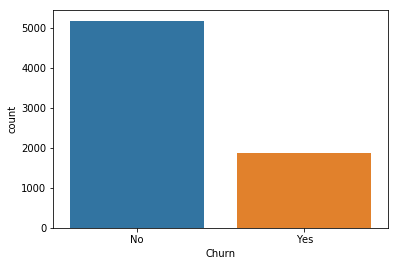

In [15]:
sn.countplot("Churn", data=master_dataset)

In [16]:
def fn_get_class_dist(values):
    all_cat_dist={}
    cat_cnts = values.value_counts()
    cat_per = cat_cnts*100/sum(cat_cnts)
    for cat_ in cat_cnts.index:
        cat_dist={}
        cat_dist["Count"]=cat_cnts[cat_]
        cat_dist["Percentage"]=cat_per[cat_]
        all_cat_dist[cat_]=cat_dist
    return all_cat_dist

In [17]:
fn_get_class_dist(master_dataset["Churn"])

{'No': {'Count': 5174, 'Percentage': 73.46301292063042},
 'Yes': {'Count': 1869, 'Percentage': 26.536987079369588}}

No class has 73% data where as yes class has 26% data. Theere is class imbalance in this dataset.

## 4. Exploratory Data Analysis

## 5. Outlier Treatment

## 6. Scaling and Encoding 

- Scaling -- Scaling is used to standardize the range of continous independent variables
- Encoding -- Encoding transforms categorical features to a format that works better with classification algorithms.
    - Label Encoding - Encode labels with value between 0 and n_classes-1. 
    - One Hot Encoding - Encode categorical integer features using a one-hot aka one-of-K scheme.

### 6.1 Scaling Continous variables

- Scaling -- Scaling is used to standardize the range of continous independent variables
    - Min Max Scaling - The function fn_minMax_scale takes a dafarame as an input and the list of columns to be scaled and returns a dataframe with the new scaled columns. This function uses MinMaxScaler() to scale the data. In MinMax Scaling all the values lie between 0 an 1. 
    - Standard Scalar - The function fn_SS_scale takes a dafarame as an input and the list of columns to be scaled and returns a dataframe with the new scaled columns. This function uses StandardScaler() to scale the data.  Mean of the varible becomes 0 with a Standard deviation of 1. 

<b> Min Max Scaling </b>

In [18]:
def fn_minMax_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = MinMaxScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"minMax_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("minMax_"+variable_)
    return df,scaled_num_features,scale_obj

<b> Standard Scaler </b>

In [19]:
def fn_SS_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = StandardScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"SS_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("SS_"+variable_)
    return df,scaled_num_features,scale_obj

In [20]:
master_dataset,scaled_ss_nums_,SS_scale_obj = fn_SS_scale(master_dataset,ints_+floats_)

In [21]:
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SS_tenure,SS_MonthlyCharges,SS_TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,-1.277445,-1.160323,-0.992611
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.066327,-0.259629,-0.172165
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,-1.236724,-0.362660,-0.958066
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.514251,-0.746535,-0.193672
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,-1.236724,0.197365,-0.938874


### 6.2  Encoding Categorical Variables
- Encoding -- Encoding transforms categorical features to a format that works better with classification algorithms.
    - Label Encoding - Encode labels with value between 0 and n_classes-1.  The function fn_label_Enc takes a dataframe as an input and a list of columns to be label encoded and returns the data frame by appeniding the new label encoded columns. 
    - One Hot Encoding - Encode categorical integer features using a one-hot aka one-of-K scheme.

<b> Label Encoding </b>

In [22]:
def fn_label_Enc(df,cat_cols):
    label_enc_obj = {}
    labelEnc_features=[]
    for variable_ in cat_cols:
        le = LabelEncoder()
        data_=df[variable_]
        le.fit(data_)
        df.loc[:,"LE_"+variable_]=le.transform(data_)
        label_enc_obj[variable_]=le
        labelEnc_features.append("LE_"+variable_)
    return df,labelEnc_features,label_enc_obj  

In [23]:
master_dataset,labEnc_categories_,labEnc_obj = fn_label_Enc(master_dataset,categories_)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SS_tenure,SS_MonthlyCharges,SS_TotalCharges,LE_gender,LE_SeniorCitizen,LE_Partner,LE_Dependents,LE_PhoneService,LE_MultipleLines,LE_InternetService,LE_OnlineSecurity,LE_OnlineBackup,LE_DeviceProtection,LE_TechSupport,LE_StreamingTV,LE_StreamingMovies,LE_Contract,LE_PaperlessBilling,LE_PaymentMethod,LE_Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,-1.277445,-1.160323,-0.992611,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.066327,-0.259629,-0.172165,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,-1.236724,-0.362660,-0.958066,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.514251,-0.746535,-0.193672,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,-1.236724,0.197365,-0.938874,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


## 6. Train Test Split

The function fn_train_test_split takes a dataframe as an input and a list of target variables and returns 4 dataframes - X Train , X Test, Y Train and Y Test. 

In [24]:
def fn_train_test_split(input_df,target):
    X = input_df.drop(target,axis=1)
    y = input_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 120)
    print(" X Shape : ",X.shape)
    print(" X Train Shape : ",X_train.shape)
    print(" X Test Shape : ",X_test.shape)
    print(" Y Shape : ",y.shape)
    print(" Y Train Shape : ",y_train.shape)
    print(" Y Test Shape : ",y_test.shape)
    return X,y,X_train,X_test,y_train,y_test

X,Y,X_train,X_test,y_train,y_test = fn_train_test_split(master_dataset,["Churn","LE_Churn"])

 X Shape :  (7043, 39)
 X Train Shape :  (5282, 39)
 X Test Shape :  (1761, 39)
 Y Shape :  (7043, 2)
 Y Train Shape :  (5282, 2)
 Y Test Shape :  (1761, 2)


## 7. Predictive Modelling

As the dataset is now all ready, we can start building predictive models.
- Each model has the following sections. 
    - Finalise Variables
    - Model Train
    - Prediction
        - Train Prediction
        - Test Prediction
    - Evaluation
        - Train Evaluation
        - Test Evaluation
    - Cross Validation
- The following models are built. 
    - Decison Trees
    - Random Forest
    - Bagging
    - Boosting

### 7.1 Decison Tree

#### 7.1.1 Finalise Variables

In [25]:
input_var = labEnc_categories_+ints_+floats_
input_var.remove("LE_Churn")
target_ = "LE_Churn"

#### 7.1.2 Model Train 

In [26]:
dtree = DecisionTreeClassifier(min_samples_split=20,
                                     max_leaf_nodes=15,
                                     min_samples_leaf=10)

dtree = DecisionTreeClassifier(max_depth=8,
                              class_weight={0:1,1:4})

dtree_model = dtree.fit(X_train[input_var], y_train[target_])

In [27]:
dtree_model

DecisionTreeClassifier(class_weight={0: 1, 1: 4}, criterion='gini',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [28]:
pd.DataFrame(dtree_model.feature_importances_,index=input_var).sort_values(0, ascending=False)

,0
LE_Contract,0.497846
MonthlyCharges,0.118170
tenure,0.103559
TotalCharges,0.068587
LE_OnlineSecurity,0.062108
LE_StreamingMovies,0.026255
LE_InternetService,0.026159
LE_MultipleLines,0.019490
LE_PaymentMethod,0.017084
LE_StreamingTV,0.013970


#### 7.1.3 Prediction

In [29]:
dtree_predictions_test = dtree_model.predict(X_test[input_var])
dtree_predictions_train = dtree_model.predict(X_train[input_var])

#### 7.1.4 Evaluation

<b> Accuracy:</b> Overall, how often is the classifier correct?<br>
(TP+TN)/total<br>
<b>Misclassification Rate::</b> Overall, how often is it wrong?<br>
(FP+FN)/total<br>
equivalent to 1 minus Accuracy also known as "Error Rate"<br>
<b>True Positive Rate::</b> When it's actually yes, how often does it predict yes?<br>
TP/actual yes<br>
also known as "Sensitivity" or "Recall"<br>
<b>False Positive Rate::</b> When it's actually no, how often does it predict yes?<br>
FP/actual no <br>
<b>Specificity: :</b>When it's actually no, how often does it predict no?<br>
TN/actual no <br>
equivalent to 1 minus False Positive Rate<br>
<b>Precision::</b> When it predicts yes, how often is it correct?<br>
TP/predicted yes <br>
<b>Prevalence: :</b>How often does the yes condition actually occur in our sample?<br>
actual yes/total<br>

In [30]:
def fn_get_classification_report(actuals,preds):
    classificaiton_report = classification_report(actuals,preds)
    conf_mat = confusion_matrix(actuals,preds)
    return classificaiton_report,conf_mat

In [31]:
def fn_get_metrics(confusion_matrix):
    tru_pos = confusion_matrix[1][1]
    tru_neg = confusion_matrix[0][0]
    fals_pos = confusion_matrix[0][1]
    fals_neg = confusion_matrix[1][0]
    
    if tru_pos+tru_neg+fals_pos+fals_neg == 0:
        accuracy = -1
    else:
        accuracy = (tru_pos+tru_neg)/(tru_pos+tru_neg+fals_pos+fals_neg)
        
    if tru_pos+fals_pos == 0:
        precision = -1
    else:
        precision = tru_pos /(tru_pos+fals_pos)
        
    if tru_pos+fals_neg == 0:
        recall = -1
    else:
        recall = tru_pos/(tru_pos+fals_neg)
        
    if precision+recall == 0:
        f1_score = -1
    else:
        f1_score = 2*precision*recall/(precision+recall)
        
    accuracy = round(accuracy,3)
    precision = round(precision,3)
    recall = round(recall,3)
    f1_score = round(f1_score,3)
    
    metrics = {"0 True Positive":tru_pos,
               "1 True Negative":tru_neg,
               "2 False Positive":fals_pos,
               "3 False Negative":fals_neg,
               "4 Accuracy":accuracy,
               "5 Precision":precision,
               "6 Recall":recall,
               "7 F1 Score":f1_score
              }
    

    return metrics

<b> Train Dataset </b>

In [32]:
dtree_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
    y_train[target_],
    dtree_predictions_train)

In [33]:
print(dtree_classificaiton_report_train)

             precision    recall  f1-score   support

          0       0.96      0.72      0.82      3883
          1       0.54      0.92      0.68      1399

avg / total       0.85      0.77      0.79      5282



In [34]:
conufsion_matrix_train

array([[2795, 1088],
       [ 105, 1294]])

In [35]:
fn_get_metrics(conufsion_matrix_train)

{'0 True Positive': 1294,
 '1 True Negative': 2795,
 '2 False Positive': 1088,
 '3 False Negative': 105,
 '4 Accuracy': 0.774,
 '5 Precision': 0.543,
 '6 Recall': 0.925,
 '7 F1 Score': 0.684}

<b> Test Dataset</b>

In [36]:
dtree_classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
    y_test[target_],
    dtree_predictions_test)

In [37]:
print(dtree_classificaiton_report_test)

             precision    recall  f1-score   support

          0       0.90      0.69      0.78      1291
          1       0.48      0.78      0.59       470

avg / total       0.79      0.72      0.73      1761



In [38]:
conufsion_matrix_test

array([[893, 398],
       [103, 367]])

In [39]:
fn_get_metrics(conufsion_matrix_test)

{'0 True Positive': 367,
 '1 True Negative': 893,
 '2 False Positive': 398,
 '3 False Negative': 103,
 '4 Accuracy': 0.716,
 '5 Precision': 0.48,
 '6 Recall': 0.781,
 '7 F1 Score': 0.594}

#### 7.1.5 Cross Validation

<b>K Fold Cross Validation </b>

In [40]:
def fn_kFold_CV(folds,X,Y,model_,input_var,target_):
    i=1
    for train_index, test_index in folds.split(X):
        print("Fold ",i)
        X_train = X.loc[train_index,input_var]
        X_test = X.loc[test_index,input_var]
        y_train = Y.loc[train_index,target_]
        y_test = Y.loc[test_index,target_]

        model = model_.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)

        classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
        y_train,
        predictions_train)

        classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
        y_test,
        predictions_test)

        train_metrics = fn_get_metrics(conufsion_matrix_train)
        test_metrics = fn_get_metrics(conufsion_matrix_test)

        metrics = [train_metrics,test_metrics]
        for metrics_ in metrics:
            print("Metrics : Accuracy - ",metrics_['4 Accuracy'],
              " Precision - ",metrics_['5 Precision'],
              "Recall - ",metrics_['6 Recall'],
                  "F1 Score - ",metrics_['7 F1 Score'])    

        i=i+1

In [41]:
folds = KFold(n_splits=5,random_state=True)
fn_kFold_CV(folds,X,Y,dtree,input_var,target_)

Fold  1
Metrics : Accuracy -  0.745  Precision -  0.511 Recall -  0.934 F1 Score -  0.66
Metrics : Accuracy -  0.689  Precision -  0.454 Recall -  0.858 F1 Score -  0.594
Fold  2
Metrics : Accuracy -  0.754  Precision -  0.523 Recall -  0.92 F1 Score -  0.667
Metrics : Accuracy -  0.718  Precision -  0.474 Recall -  0.83 F1 Score -  0.603
Fold  3
Metrics : Accuracy -  0.754  Precision -  0.521 Recall -  0.943 F1 Score -  0.671
Metrics : Accuracy -  0.688  Precision -  0.449 Recall -  0.824 F1 Score -  0.582
Fold  4
Metrics : Accuracy -  0.762  Precision -  0.528 Recall -  0.931 F1 Score -  0.674
Metrics : Accuracy -  0.684  Precision -  0.452 Recall -  0.775 F1 Score -  0.571
Fold  5
Metrics : Accuracy -  0.763  Precision -  0.529 Recall -  0.932 F1 Score -  0.675
Metrics : Accuracy -  0.707  Precision -  0.475 Recall -  0.789 F1 Score -  0.593


<b> Corss Val Score </b>

In [42]:
dtree_crossVal_scores = cross_val_score(dtree, master_dataset[input_var], 
                                        master_dataset[target_], cv=5, scoring='precision')
# print(dtree_crossVal_scores)
print("Precision: %0.2f (+/- %0.2f)" % (dtree_crossVal_scores.mean(), dtree_crossVal_scores.std() * 2))

Precision: 0.46 (+/- 0.03)


<b>Stratified k-fold cross validation</b>

In [43]:
def fn_strat_KFold(folds,X,Y,input_var,target_):
    i=1
    for train_index, test_index in folds.split(master_dataset[input_var],master_dataset[target_]):
        print("Fold ",i)
        X_train = X.loc[train_index,input_var]
        X_test = X.loc[test_index,input_var]
        y_train = Y.loc[train_index,target_]
        y_test = Y.loc[test_index,target_]

        dtree_model = dtree.fit(X_train, y_train)
        dtree_predictions_train = dtree_model.predict(X_train)
        dtree_predictions_test = dtree_model.predict(X_test)

        dtree_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
        y_train,
        dtree_predictions_train)

        dtree_classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
        y_test,
        dtree_predictions_test)

        train_metrics = fn_get_metrics(conufsion_matrix_train)
        test_metrics = fn_get_metrics(conufsion_matrix_test)

        metrics = [train_metrics,test_metrics]
        for metrics_ in metrics:
            print("Metrics : Accuracy - ",metrics_['4 Accuracy'],
              " Precision - ",metrics_['5 Precision'],
              "Recall - ",metrics_['6 Recall'],
                  "F1 Score - ",metrics_['7 F1 Score'])    

        i=i+1

In [44]:
folds = StratifiedKFold(n_splits=5,random_state=None,shuffle=True)
fn_strat_KFold(folds,X,Y,input_var,target_)

Fold  1
Metrics : Accuracy -  0.767  Precision -  0.535 Recall -  0.93 F1 Score -  0.679
Metrics : Accuracy -  0.693  Precision -  0.455 Recall -  0.791 F1 Score -  0.578
Fold  2
Metrics : Accuracy -  0.734  Precision -  0.499 Recall -  0.943 F1 Score -  0.653
Metrics : Accuracy -  0.667  Precision -  0.434 Recall -  0.84 F1 Score -  0.572
Fold  3
Metrics : Accuracy -  0.771  Precision -  0.54 Recall -  0.92 F1 Score -  0.681
Metrics : Accuracy -  0.719  Precision -  0.483 Recall -  0.821 F1 Score -  0.608
Fold  4
Metrics : Accuracy -  0.758  Precision -  0.524 Recall -  0.94 F1 Score -  0.673
Metrics : Accuracy -  0.699  Precision -  0.462 Recall -  0.802 F1 Score -  0.586
Fold  5
Metrics : Accuracy -  0.764  Precision -  0.532 Recall -  0.918 F1 Score -  0.673
Metrics : Accuracy -  0.701  Precision -  0.464 Recall -  0.802 F1 Score -  0.587


### 7.2 Decison Tree - Probabalities

In the model we'll try to predict the probalities of a customer churn and try to choose a cutoff value based on ROC curve.

#### 7.2.1 Model Train 

In [45]:
X,Y,X_train,X_test,y_train,y_test = fn_train_test_split(master_dataset,["Churn","LE_Churn"])
dtree = DecisionTreeClassifier(min_samples_split=20,
                                     max_leaf_nodes=15,
                                     min_samples_leaf=10,class_weight={0:1,1:20})

dtree = DecisionTreeClassifier(max_depth=8,
                              class_weight={0:1,1:4})


dtree_model = dtree.fit(X_train[input_var], y_train[target_])

 X Shape :  (7043, 39)
 X Train Shape :  (5282, 39)
 X Test Shape :  (1761, 39)
 Y Shape :  (7043, 2)
 Y Train Shape :  (5282, 2)
 Y Test Shape :  (1761, 2)


#### 7.2.3 Prediction

In [46]:
dtree_predictions_test = dtree_model.predict_proba(X_test[input_var])
dtree_predictions_train = dtree_model.predict_proba(X_train[input_var])

<b> Choosing appropraite cut-off value - Method 1 </b>
In this method, we try to plot the ditributions of each class and decide the best cut-off value. 

Text(0,0.5,'Density')

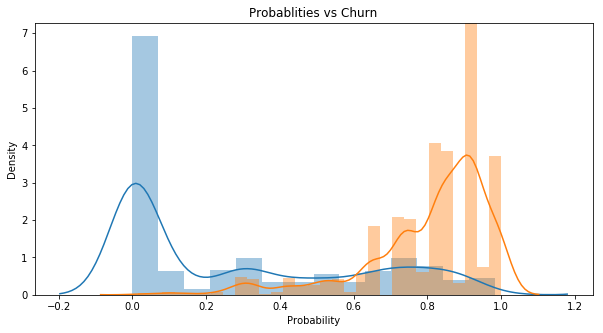

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
g = sn.distplot(dtree_predictions_train[y_train[target_]==0,1],ax=ax)
g = sn.distplot(dtree_predictions_train[y_train[target_]==1,1],ax=ax)
g.set_title("Probablities vs Churn")
g.set_xlabel("Probability")
g.set_ylabel("Density")

As the probability values increases, a csutomer is likely to churn. Comparing the distributions of class 0 and 1, we can conlude that, the customers who do not churn is decreasing after 0.6 and most of the customers who churned are below 0.6. Setting the cutoff value to 0.6 could be a better apporach. 

<b> Choosing appropraite cut-off value - Method 2 - ROC Curve </b><br>
ROC curve’s purpose is used to visualize and quantify the tradeoff we’re making between the true positive rate (TPR) and false positive rate (FPR) measures. This curve is created by plotting the true positive rate (TPR) on the y axis against the false positive rate (FPR) on the x axis at various cutoff settings ( between 0 and 1 ).

The ROC curve does this by plotting sensitivity, the probability of predicting a real positive will be a positive(TPR), against 1-specificity, the probability of predicting a real negative will be a positive(FPR).

In [48]:
fpr, tpr, threshold = roc_curve(y_train[target_], dtree_predictions_train[:, 1])
roc_auc = auc(fpr, tpr)
tpr_dtree = tpr
fpr_dtree = fpr

fpr, tpr, threshold = roc_curve(y_test[target_], dtree_predictions_test[:, 1])
roc_auc = auc(fpr, tpr)
tpr_dtree_ = tpr
fpr_dtree_ = fpr

AUC Value  0.7857235855431218
Thresholds  [2.         1.         0.98245614 0.98220641 0.96551724 0.96
 0.94117647 0.93203883 0.91637631 0.90780142 0.88888889 0.87804878
 0.86746988 0.85714286 0.83916084 0.83526682 0.83333333 0.82758621
 0.82608696 0.81355932 0.8        0.77192982 0.76190476 0.75
 0.74576271 0.74545455 0.73214286 0.72727273 0.70588235 0.66666667
 0.65822785 0.6568915  0.625      0.61971831 0.59259259 0.57142857
 0.54545455 0.54320988 0.53333333 0.53061224 0.5        0.47368421
 0.47058824 0.42857143 0.41025641 0.4        0.36363636 0.33333333
 0.31818182 0.30769231 0.28571429 0.28025478 0.23529412 0.21052632
 0.16666667 0.14285714 0.12903226 0.10526316 0.09090909 0.05263158
 0.04494382 0.015625   0.        ]


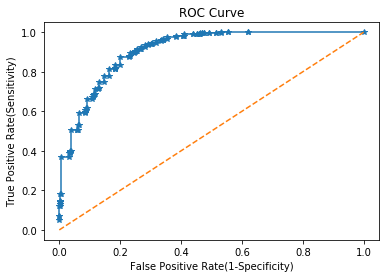

In [49]:
plt.step(fpr_dtree,tpr_dtree,marker='*')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.xlabel('False Positive Rate(1-Specificity)')
plt.title('ROC Curve')
print('AUC Value ',roc_auc)
print('Thresholds ',threshold)

In [50]:
for i in threshold: 
    print(i)
    dtree_predictions_train_ = np.where(dtree_predictions_train[:,1]>i,1,0)
    dtree_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
        y_train[target_],
        dtree_predictions_train_)

    print(dtree_classificaiton_report_train)
cut_off=0.7272727272727273

2.0
             precision    recall  f1-score   support

          0       0.74      1.00      0.85      3883
          1       0.00      0.00      0.00      1399

avg / total       0.54      0.74      0.62      5282

1.0
             precision    recall  f1-score   support

          0       0.74      1.00      0.85      3883
          1       0.00      0.00      0.00      1399

avg / total       0.54      0.74      0.62      5282

0.9824561403508771
             precision    recall  f1-score   support

          0       0.75      1.00      0.85      3883
          1       1.00      0.05      0.10      1399

avg / total       0.81      0.75      0.65      5282

0.9822064056939501
             precision    recall  f1-score   support

          0       0.75      1.00      0.86      3883
          1       0.98      0.07      0.13      1399

avg / total       0.81      0.75      0.67      5282

0.9655172413793104
             precision    recall  f1-score   support

          0       0.7

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.88      0.89      0.89      3883
          1       0.69      0.67      0.68      1399

avg / total       0.83      0.83      0.83      5282

0.7619047619047619
             precision    recall  f1-score   support

          0       0.89      0.89      0.89      3883
          1       0.68      0.68      0.68      1399

avg / total       0.83      0.83      0.83      5282

0.75
             precision    recall  f1-score   support

          0       0.89      0.88      0.89      3883
          1       0.68      0.69      0.68      1399

avg / total       0.83      0.83      0.83      5282

0.7457627118644068
             precision    recall  f1-score   support

          0       0.89      0.87      0.88      3883
          1       0.67      0.71      0.69      1399

avg / total       0.83      0.83      0.83      5282

0.7454545454545455
             precision    recall  f1-score   support

          0       0.90  

From the above ROC curve, choosing a cutoff between 0.7272727272727273 can give a good TPR and less FPR. 

<b> Choosing appropraite cut-off value - Method 3 - PR Curve </b><br>

Threshold [0.015625   0.04494382 0.05263158 0.09090909 0.10526316 0.12903226
 0.14285714 0.16666667 0.21052632 0.23529412 0.28025478 0.28571429
 0.30769231 0.31818182 0.33333333 0.36363636 0.4        0.41025641
 0.42857143 0.47058824 0.47368421 0.5        0.53061224 0.53333333
 0.54320988 0.54545455 0.57142857 0.59259259 0.61971831 0.625
 0.6568915  0.65822785 0.66666667 0.70588235 0.72727273 0.73214286
 0.74545455 0.74576271 0.75       0.76190476 0.77192982 0.8
 0.81355932 0.82608696 0.82758621 0.83333333 0.83526682 0.83916084
 0.85714286 0.86746988 0.87804878 0.88888889 0.90780142 0.91637631
 0.93203883 0.94117647 0.96       0.96551724 0.98220641 0.98245614
 1.        ]


(0.0, 1.0)

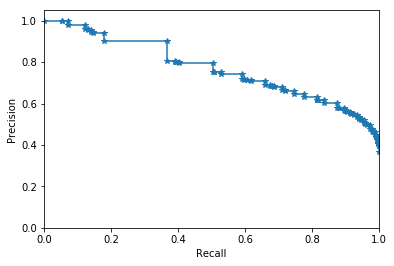

In [51]:
precision, recall, threshold = precision_recall_curve(y_train[target_], dtree_predictions_train[:, 1])
print("Threshold",threshold)
plt.step(recall, precision,marker='*')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [52]:
for i in threshold: 
    print(i)
    dtree_predictions_train_ = np.where(dtree_predictions_train[:,1]>i,1,0)
    dtree_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
        y_train[target_],
        dtree_predictions_train_)

    print(dtree_classificaiton_report_train)
    
cut_off_ = 0.7058823529411765

0.015625
             precision    recall  f1-score   support

          0       1.00      0.45      0.62      3883
          1       0.39      1.00      0.56      1399

avg / total       0.84      0.59      0.60      5282

0.0449438202247191
             precision    recall  f1-score   support

          0       1.00      0.47      0.64      3883
          1       0.40      1.00      0.57      1399

avg / total       0.84      0.61      0.62      5282

0.05263157894736842
             precision    recall  f1-score   support

          0       1.00      0.49      0.65      3883
          1       0.41      1.00      0.58      1399

avg / total       0.84      0.62      0.64      5282

0.09090909090909091
             precision    recall  f1-score   support

          0       1.00      0.51      0.67      3883
          1       0.42      1.00      0.59      1399

avg / total       0.84      0.64      0.65      5282

0.10526315789473684
             precision    recall  f1-score   support

             precision    recall  f1-score   support

          0       0.84      0.94      0.89      3883
          1       0.75      0.50      0.60      1399

avg / total       0.82      0.82      0.81      5282

0.8674698795180723
             precision    recall  f1-score   support

          0       0.82      0.96      0.88      3883
          1       0.80      0.40      0.53      1399

avg / total       0.81      0.81      0.79      5282

0.8780487804878049
             precision    recall  f1-score   support

          0       0.82      0.96      0.88      3883
          1       0.80      0.40      0.53      1399

avg / total       0.81      0.81      0.79      5282

0.8888888888888888
             precision    recall  f1-score   support

          0       0.81      0.96      0.88      3883
          1       0.80      0.39      0.53      1399

avg / total       0.81      0.81      0.79      5282

0.9078014184397163
             precision    recall  f1-score   support

          

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 7.2.4 Evaluation

<b> Setting cutoff value using Method 1 </b><br>
From the above cutoff method 1, let's set the cutoff to 0.3 and evaluate the model's perfromance.

<b> Train Dataset </b>

In [53]:
dtree_predictions_train_ = np.where(dtree_predictions_train[:,1]>0.6,1,0)
dtree_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
    y_train[target_],
    dtree_predictions_train_)

In [54]:
print(dtree_classificaiton_report_train)

             precision    recall  f1-score   support

          0       0.95      0.75      0.84      3883
          1       0.57      0.90      0.70      1399

avg / total       0.85      0.79      0.80      5282



In [55]:
conufsion_matrix_train

array([[2931,  952],
       [ 146, 1253]])

In [56]:
fn_get_metrics(conufsion_matrix_train)

{'0 True Positive': 1253,
 '1 True Negative': 2931,
 '2 False Positive': 952,
 '3 False Negative': 146,
 '4 Accuracy': 0.792,
 '5 Precision': 0.568,
 '6 Recall': 0.896,
 '7 F1 Score': 0.695}

<b> Test Dataset</b>

In [57]:
dtree_predictions_test_ = np.where(dtree_predictions_test[:,1]>0.6,1,0)
dtree_classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
    y_test[target_],
    dtree_predictions_test_)

In [58]:
print(dtree_classificaiton_report_test)

             precision    recall  f1-score   support

          0       0.88      0.73      0.80      1291
          1       0.49      0.73      0.59       470

avg / total       0.78      0.73      0.74      1761



In [59]:
conufsion_matrix_test

array([[936, 355],
       [127, 343]])

In [60]:
fn_get_metrics(conufsion_matrix_test)

{'0 True Positive': 343,
 '1 True Negative': 936,
 '2 False Positive': 355,
 '3 False Negative': 127,
 '4 Accuracy': 0.726,
 '5 Precision': 0.491,
 '6 Recall': 0.73,
 '7 F1 Score': 0.587}

<b> Setting cutoff value using Method 2 - ROC Curve </b><br>
From the above cutoff method 2, let's set the cutoff to 0.35 and evaluate the model's perfromance.

<b> Train Dataset </b>

In [61]:
dtree_predictions_train_ = np.where(dtree_predictions_train[:,1]>cut_off,1,0)
dtree_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
    y_train[target_],
    dtree_predictions_train_)

In [62]:
print(dtree_classificaiton_report_train)

             precision    recall  f1-score   support

          0       0.91      0.84      0.87      3883
          1       0.63      0.78      0.70      1399

avg / total       0.84      0.82      0.83      5282



In [63]:
conufsion_matrix_train

array([[3255,  628],
       [ 312, 1087]])

In [64]:
fn_get_metrics(conufsion_matrix_train)

{'0 True Positive': 1087,
 '1 True Negative': 3255,
 '2 False Positive': 628,
 '3 False Negative': 312,
 '4 Accuracy': 0.822,
 '5 Precision': 0.634,
 '6 Recall': 0.777,
 '7 F1 Score': 0.698}

In [65]:
print("AUC of train set is :",roc_auc)

AUC of train set is : 0.7857235855431218


<b> Test Dataset</b>

In [66]:
dtree_predictions_test_ = np.where(dtree_predictions_test[:,1]>cut_off,1,0)
dtree_classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
    y_test[target_],
    dtree_predictions_test_)

In [67]:
print(dtree_classificaiton_report_test)

             precision    recall  f1-score   support

          0       0.86      0.81      0.83      1291
          1       0.55      0.63      0.59       470

avg / total       0.78      0.76      0.77      1761



In [68]:
conufsion_matrix_test

array([[1048,  243],
       [ 173,  297]])

In [69]:
fn_get_metrics(conufsion_matrix_test)

{'0 True Positive': 297,
 '1 True Negative': 1048,
 '2 False Positive': 243,
 '3 False Negative': 173,
 '4 Accuracy': 0.764,
 '5 Precision': 0.55,
 '6 Recall': 0.632,
 '7 F1 Score': 0.588}

<b> Setting cutoff value using Method 3 - PR Curve </b><br>
From the above cutoff method 3, let's set the cutoff using PR curve and evaluate the model's perfromance.

<b> Train Dataset </b>

In [70]:
dtree_predictions_train_ = np.where(dtree_predictions_train[:,1]>cut_off_,1,0)
dtree_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
    y_train[target_],
    dtree_predictions_train_)

In [71]:
print(dtree_classificaiton_report_train)

             precision    recall  f1-score   support

          0       0.92      0.82      0.87      3883
          1       0.62      0.81      0.70      1399

avg / total       0.84      0.82      0.82      5282



In [72]:
conufsion_matrix_train

array([[3177,  706],
       [ 260, 1139]])

In [73]:
fn_get_metrics(conufsion_matrix_train)

{'0 True Positive': 1139,
 '1 True Negative': 3177,
 '2 False Positive': 706,
 '3 False Negative': 260,
 '4 Accuracy': 0.817,
 '5 Precision': 0.617,
 '6 Recall': 0.814,
 '7 F1 Score': 0.702}

In [74]:
print("AUC of train set is :",roc_auc)

AUC of train set is : 0.7857235855431218


<b> Test Dataset</b>

In [75]:
dtree_predictions_test_ = np.where(dtree_predictions_test[:,1]>cut_off_,1,0)
dtree_classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
    y_test[target_],
    dtree_predictions_test_)

In [76]:
print(dtree_classificaiton_report_test)

             precision    recall  f1-score   support

          0       0.86      0.79      0.82      1291
          1       0.53      0.66      0.59       470

avg / total       0.78      0.75      0.76      1761



In [77]:
conufsion_matrix_test

array([[1017,  274],
       [ 160,  310]])

In [78]:
fn_get_metrics(conufsion_matrix_test)

{'0 True Positive': 310,
 '1 True Negative': 1017,
 '2 False Positive': 274,
 '3 False Negative': 160,
 '4 Accuracy': 0.754,
 '5 Precision': 0.531,
 '6 Recall': 0.66,
 '7 F1 Score': 0.588}

### 7.3 Bagging

<b> Model Definition </b>

In [79]:
X,Y,X_train,X_test,y_train,y_test = fn_train_test_split(master_dataset,["Churn","LE_Churn"])
dtree = DecisionTreeClassifier(max_depth=7,
                              class_weight={0:1,1:4})

baggingClassfier = BaggingClassifier(base_estimator=dtree, 
                                     n_estimators=2000,
                                     max_samples=0.7,
                                     bootstrap_features=False,
                                    n_jobs=4)

 X Shape :  (7043, 39)
 X Train Shape :  (5282, 39)
 X Test Shape :  (1761, 39)
 Y Shape :  (7043, 2)
 Y Train Shape :  (5282, 2)
 Y Test Shape :  (1761, 2)


<b> Model </b>

In [80]:
baggingClassfier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 4}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.7, n_estimators=2000, n_jobs=4, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

<b> Training </b>

In [81]:
baggingClassfier_model = baggingClassfier.fit(X_train[input_var], y_train[target_])

<b> Predictions </b>

In [82]:
#predict
baggingClassfier_predictions_test = baggingClassfier_model.predict(X_test[input_var])
baggingClassfier_predictions_train = baggingClassfier_model.predict(X_train[input_var]) 

#predict_proba
baggingClassfier_predictions_test_ = baggingClassfier_model.predict_proba(X_test[input_var])
baggingClassfier_predictions_train_ = baggingClassfier_model.predict_proba(X_train[input_var]) 

<b> Evaluation </b>

In [83]:
baggingClassfier_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
    y_train[target_],
    baggingClassfier_predictions_train)
print("Train ")
print(baggingClassfier_classificaiton_report_train)

Train 
             precision    recall  f1-score   support

          0       0.95      0.76      0.84      3883
          1       0.57      0.88      0.69      1399

avg / total       0.85      0.79      0.80      5282



In [84]:
baggingClassfier_classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
    y_test[target_],
    baggingClassfier_predictions_test)
print("Test ")
print(baggingClassfier_classificaiton_report_test)

Test 
             precision    recall  f1-score   support

          0       0.90      0.75      0.81      1291
          1       0.52      0.77      0.62       470

avg / total       0.80      0.75      0.76      1761



In [85]:
#Train
fpr, tpr, threshold = roc_curve(y_train[target_], baggingClassfier_predictions_train_[:, 1])
fpr_baggingClassfier = fpr
tpr_baggingClassfier = tpr

#Test
fpr, tpr, threshold = roc_curve(y_test[target_], baggingClassfier_predictions_test_[:, 1])
fpr_baggingClassfier_ = fpr
tpr_baggingClassfier_ = tpr

In [86]:
# for depth_ in [2,4,6,8,10,12,15,20,25,30]:
#     dtree = DecisionTreeClassifier(max_depth=depth_,class_weight={0:1,1:4})
#     recall_=[]
#     nestimator_ = []
#     for nest_ in np.arange(1,200):
#         BaggingClassifier(base_estimator=dtree, n_estimators=nest_,max_samples=2000,n_jobs=6)
#         baggingClassfier_model = baggingClassfier.fit(X_train[input_var], y_train[target_])

#         baggingClassfier_predictions_train = baggingClassfier_model.predict(X_train[input_var])

#         baggingClassfier_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
#         y_train[target_],
#         baggingClassfier_predictions_train)

#         metrics_train = fn_get_metrics(conufsion_matrix_train)
#         recall_.append(metrics_train['6 Recall'])
#         nestimator_.append(nest_)

#         plt.step(nestimator_, recall_, linestyle='--')

#         plt.ylim([0.0, 1.05])
# plt.ylim([0.8, 0.9]) 
# plt.xlabel('Estimators')
# plt.ylabel('Recall')
# plt.show()

<b> Cross Validation - KFold </b>

In [87]:
folds = KFold(n_splits=5,random_state=True)
fn_kFold_CV(folds,X,Y,baggingClassfier,input_var,target_)

Fold  1
Metrics : Accuracy -  0.788  Precision -  0.565 Recall -  0.88 F1 Score -  0.688
Metrics : Accuracy -  0.745  Precision -  0.512 Recall -  0.828 F1 Score -  0.633
Fold  2
Metrics : Accuracy -  0.792  Precision -  0.571 Recall -  0.892 F1 Score -  0.696
Metrics : Accuracy -  0.761  Precision -  0.524 Recall -  0.802 F1 Score -  0.634
Fold  3
Metrics : Accuracy -  0.794  Precision -  0.573 Recall -  0.882 F1 Score -  0.695
Metrics : Accuracy -  0.742  Precision -  0.505 Recall -  0.814 F1 Score -  0.623
Fold  4
Metrics : Accuracy -  0.79  Precision -  0.564 Recall -  0.889 F1 Score -  0.691
Metrics : Accuracy -  0.736  Precision -  0.509 Recall -  0.754 F1 Score -  0.608
Fold  5
Metrics : Accuracy -  0.789  Precision -  0.564 Recall -  0.889 F1 Score -  0.69
Metrics : Accuracy -  0.763  Precision -  0.542 Recall -  0.782 F1 Score -  0.64


### 7.4 Ada Boosting

<b> Model Definition </b>

In [298]:
X,Y,X_train,X_test,y_train,y_test = fn_train_test_split(master_dataset,["Churn","LE_Churn"])
dtree = DecisionTreeClassifier(max_depth=6,class_weight={0:1,1:4})

adaBoostClassfier = AdaBoostClassifier(base_estimator=dtree,
                                       learning_rate=0.001,
                                     n_estimators=1000)

 X Shape :  (7043, 39)
 X Train Shape :  (5282, 39)
 X Test Shape :  (1761, 39)
 Y Shape :  (7043, 2)
 Y Train Shape :  (5282, 2)
 Y Test Shape :  (1761, 2)


<b> Model </b>

In [299]:
adaBoostClassfier

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 4}, criterion='gini',
            max_depth=6, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.001, n_estimators=1000, random_state=None)

<b> Training </b>

In [300]:
adaBoostClassfier_model = adaBoostClassfier.fit(X_train[input_var], y_train[target_])

<b> Predictions </b>

In [301]:
#predict
adaBoostClassfier_predictions_test = adaBoostClassfier_model.predict(X_test[input_var])
adaBoostClassfier_predictions_train = adaBoostClassfier_model.predict(X_train[input_var]) 

#predict_proba
adaBoostClassfier_predictions_test_ = adaBoostClassfier_model.predict_proba(X_test[input_var])
adaBoostClassfier_predictions_train_ = adaBoostClassfier_model.predict_proba(X_train[input_var]) 

<b> Evaluation </b>

In [302]:
adaBoostClassfier_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
    y_train[target_],
    adaBoostClassfier_predictions_train)
print("Train ")
print(adaBoostClassfier_classificaiton_report_train)

Train 
             precision    recall  f1-score   support

          0       0.97      0.79      0.87      3883
          1       0.61      0.94      0.74      1399

avg / total       0.88      0.83      0.84      5282



In [303]:
adaBoostClassfier_classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
    y_test[target_],
    adaBoostClassfier_predictions_test)
print("Test ")
print(adaBoostClassfier_classificaiton_report_test)

Test 
             precision    recall  f1-score   support

          0       0.88      0.74      0.81      1291
          1       0.51      0.72      0.60       470

avg / total       0.78      0.74      0.75      1761



In [304]:
#Train
fpr, tpr, threshold = roc_curve(y_train[target_], adaBoostClassfier_predictions_train_[:, 1])
fpr_adaBoostClassfier = fpr
tpr_adaBoostClassfier = tpr

#Test
fpr, tpr, threshold = roc_curve(y_test[target_], adaBoostClassfier_predictions_test_[:, 1])
fpr_adaBoostClassfier_ = fpr
tpr_adaBoostClassfier_ = tpr

<b> Cross Validation - KFold </b>

In [305]:
folds = KFold(n_splits=5,random_state=True)
fn_kFold_CV(folds,X,Y,adaBoostClassfier,input_var,target_)

Fold  1
Metrics : Accuracy -  0.821  Precision -  0.604 Recall -  0.945 F1 Score -  0.737
Metrics : Accuracy -  0.742  Precision -  0.509 Recall -  0.783 F1 Score -  0.617
Fold  2
Metrics : Accuracy -  0.811  Precision -  0.591 Recall -  0.949 F1 Score -  0.728
Metrics : Accuracy -  0.749  Precision -  0.509 Recall -  0.788 F1 Score -  0.619
Fold  3
Metrics : Accuracy -  0.822  Precision -  0.606 Recall -  0.945 F1 Score -  0.739
Metrics : Accuracy -  0.742  Precision -  0.506 Recall -  0.803 F1 Score -  0.621
Fold  4
Metrics : Accuracy -  0.829  Precision -  0.612 Recall -  0.96 F1 Score -  0.748
Metrics : Accuracy -  0.737  Precision -  0.511 Recall -  0.738 F1 Score -  0.604
Fold  5
Metrics : Accuracy -  0.817  Precision -  0.597 Recall -  0.942 F1 Score -  0.731
Metrics : Accuracy -  0.741  Precision -  0.514 Recall -  0.747 F1 Score -  0.609


### All Models' Perfromance

<b> Train </b>

AUC Value Decision Tree : 0.903
AUC Value Bagging : 0.902
AUC Value AdaBoost : 0.936


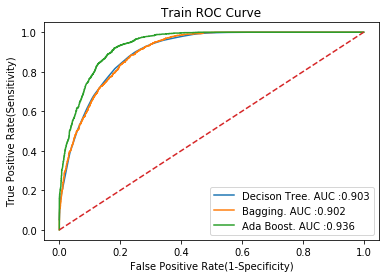

In [306]:
auc_dtree=round(auc(fpr_dtree, tpr_dtree),3)
auc_bagging=round(auc(fpr_baggingClassfier, tpr_baggingClassfier),3)
auc_adaBoost=round(auc(fpr_adaBoostClassfier,tpr_adaBoostClassfier),3)

print('AUC Value Decision Tree :',auc_dtree)
print('AUC Value Bagging :',auc_bagging)
print('AUC Value AdaBoost :',auc_adaBoost)

plt.plot(fpr_dtree,tpr_dtree, label='Decison Tree. AUC :'+str(auc_dtree))
plt.plot(fpr_baggingClassfier,tpr_baggingClassfier, label='Bagging. AUC :'+str(auc_bagging))
plt.plot(fpr_adaBoostClassfier,tpr_adaBoostClassfier, label='Ada Boost. AUC :'+str(auc_adaBoost))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylabel('True Positive Rate(Sensitivity)')
plt.xlabel('False Positive Rate(1-Specificity)')
plt.title('Train ROC Curve')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()


<b> Test </b>

AUC Value Decision Tree : 0.786
AUC Value Bagging : 0.837
AUC Value AdaBoost : 0.815


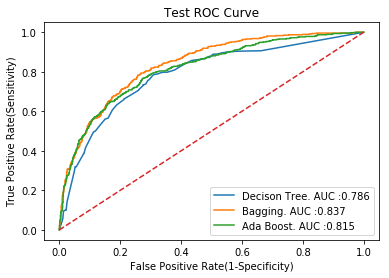

In [307]:
auc_dtree_=round(auc(fpr_dtree_, tpr_dtree_),3)
auc_bagging_=round(auc(fpr_baggingClassfier_, tpr_baggingClassfier_),3)
auc_adaBoost_=round(auc(fpr_adaBoostClassfier_,tpr_adaBoostClassfier_),3)

print('AUC Value Decision Tree :',auc_dtree_)
print('AUC Value Bagging :',auc_bagging_)
print('AUC Value AdaBoost :',auc_adaBoost_)

plt.plot(fpr_dtree_,tpr_dtree_, label='Decison Tree. AUC :'+str(auc_dtree_))
plt.plot(fpr_baggingClassfier_,tpr_baggingClassfier_, label='Bagging. AUC :'+str(auc_bagging_))
plt.plot(fpr_adaBoostClassfier_,tpr_adaBoostClassfier_, label='Ada Boost. AUC :'+str(auc_adaBoost_))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylabel('True Positive Rate(Sensitivity)')
plt.xlabel('False Positive Rate(1-Specificity)')
plt.title('Test ROC Curve')
plt.legend()